# Regression with Deep Ensembles for Uncertainty Estimation
##  Dataset: One-Dimensional Synthetic Data
This notebook demonstrates the regression implementation based on the paper "Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles" (https://arxiv.org/abs/1612.01474). The model is trained on a simple 1D synthetic dataset generated from the function 10·sin(x), with added Gaussian noise from N(0, 3²) and N(0, 1²).
To capture predictive uncertainty, we utilize an ensemble of five neural networks.

## Import Modules

* import tensorflow.compat.v1 as tf: Imports TensorFlow in version 1 compatibility mode, allowing use of TF1-style graph-based execution and functions like tf.placeholder.

* import numpy as np: Imports NumPy, a library for numerical computing, used for creating arrays, performing mathematical operations, and handling data structures.

* import matplotlib.pyplot as plt: Imports Matplotlib's pyplot module, which is used for plotting and visualizing data (e.g., line plots, scatter plots).

* from sklearn.utils import shuffle: Imports the shuffle function from scikit-learn to randomly shuffle arrays, useful for mixing training data before model training.

In [49]:
# Import necessary libraries
import tensorflow.compat.v1 as tf  # ...........................................TensorFlow (v1 compatibility)
import numpy as np                 # ...........................................For numerical operations
import matplotlib.pyplot as plt    # ...........................................For plotting
from sklearn.utils import shuffle  # ............................................To shuffle training data


## Training Hyperparameters
* learning_rate = 0.01
Defines how quickly the model updates its weights during training. A higher rate may lead to faster learning but risks overshooting optimal values.

* epsilon_value = 1e-8
A small constant added to the denominator in the optimizer to prevent division by zero, especially used in Adam optimization.

* total_iterations = 5000
The number of training steps or iterations the model will go through during learning.

* batch_size_value = 256
The number of data samples used in each training batch. Larger batches provide more stable updates but require more memory.

* gpu_memory_fraction = 0.2
Sets the maximum fraction of available GPU memory TensorFlow is allowed to use (in this case, 20%).

* test_data_ratio = 0.1
Indicates that 10% of the total dataset is reserved for testing, and the remaining 90% is used for training.

## Neural Network Architecture (Layer Sizes)
* ensemble_models = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5']
Names of five separate neural network models used in the ensemble method for uncertainty estimation.

* fc1_layer_dims = [1, 256]
Dimensions for the first fully connected layer: input size is 1, output size is 256 neurons.

* fc2_layer_dims = [256, 512]
Dimensions for the second fully connected layer: input size is 256, output size is 512 neurons.

* output_mu_dims = [512, 1]
Defines the layer that predicts the mean (μ) of the output distribution; input is 512, output is 1.

* output_sigma_dims = [512, 1]
Defines the layer that predicts the variance (σ²) or uncertainty of the output; input is 512, output is 1.

## Shuffle the Data
shuffle(...): Randomly mixes the order of x and y data to avoid ordered bias during training

Split Data into Training and Test Sets
num_training_samples: Calculates number of training samples (90% of total).

* num_testing_samples: Calculates number of test samples (10% of total).

* train_features, train_labels: Subsets of x and y for training.

* test_features, test_labels: Subsets of x and y for testing.

## Visualize the Data
* plt.plot(input_data_x, noisy_output_y, ...): Plots the shuffled noisy data as black dots.

* plt.plot(true_input_x, true_output_y, ...): Plots the true 10·sin(x) curve in green.

* Styling:

* Grid lines are added for readability.

* X and Y axis are labeled.

* A descriptive title with noise distribution details is shown.

* The legend differentiates between noisy and true data.

* tight_layout() improves spacing around plot elements.

* plt.show() displays the plot.

In [50]:
# Training Hyperparameters
# ------------------------------------------
learning_rate = 0.01        #................................................... Learning rate for the optimizer
epsilon_value = 1e-8        #................................................... Epsilon to avoid division by zero (Adam optimizer)
total_iterations = 5000     #................................................... Total number of training steps
batch_size_value = 256      #................................................... Number of samples per training batch
# GPU memory usage fraction (used if GPU is available)
gpu_memory_fraction = 0.2
# Ratio of test data in the total dataset
test_data_ratio = 0.1
# Neural Network Architecture (Layer Sizes)
# ------------------------------------------
ensemble_models = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5']  # List of 5 ensemble model names

# Fully connected layer sizes: [input_dim, output_dim]
fc1_layer_dims =    [1, 256]    #.................................................. First hidden layer
fc2_layer_dims =    [256, 512]  #.................................................. Second hidden layer
output_mu_dims =    [512, 1]    #.................................................. Output layer for predicting mean
output_sigma_dims = [512, 1]    #.................................................. Output layer for predicting uncertainty (variance)


## Making Toy Dataset
## Synthetic Data Generation Parameters

range_limit = 3: Sets the x-axis range of the dataset to go from -3 to +3.

step_size = 0.005: Defines the step interval between x values, controlling how densely the input space is sampled.

noise_std_left = 3: Standard deviation of noise added to output values when x < 0.

noise_std_right = 1: Standard deviation of noise added to output values when x ≥ 0.

dummy_data_label = 1: Reserved placeholder (not used in this code).

## Generate Input x Values
* input_data_x = np.arange(...): Creates x values from -3 to 3 with steps of 0.005.

* input_data_x = np.reshape(...): Reshapes x values to a column vector format.

* true_input_x = input_data_x.copy(): Stores a clean (non-shuffled) copy of x values for later use in plotting.

## Initialize and Generate y Values
* noisy_output_y and true_output_y: Arrays to store noisy and clean output values.

* The for loop fills these arrays:

* If x < 0, noise from N(0, 3²) is added to 10·sin(x).

* If x ≥ 0, noise from N(0, 1²) is added.

* true_output_y stores the exact value of 10·sin(x) without noise.

Train data shape: (1080, 1)
Test data shape: (121, 1)


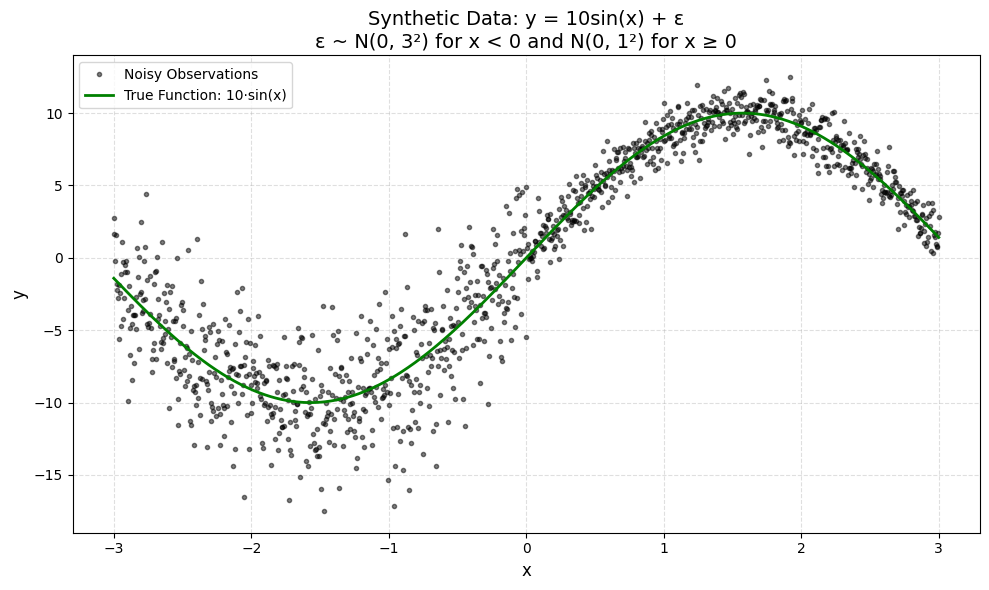

In [63]:
# Synthetic Data Generation Parameters
# ------------------------------------------
range_limit = 3             #................................................... Range of x values: -3 to +3
step_size = 0.005           #................................................... Step size in x
noise_std_left = 3          #................................................... Standard deviation for x < 0
noise_std_right = 1         #................................................... Standard deviation for x >= 0
dummy_data_label = 1        #................................................... Not used but reserved
# Generate input x values: shape (n, 1)
input_data_x = np.arange(-range_limit, range_limit + step_size, step_size)
input_data_x = np.reshape(input_data_x, [input_data_x.shape[0], 1])
true_input_x = input_data_x.copy() #............................................ Save clean version of x
# Initialize arrays to store noisy and true y values
noisy_output_y = np.zeros([input_data_x.shape[0], 1])
true_output_y = np.zeros([input_data_x.shape[0], 1])
# Generate noisy and true y values based on x
for idx in range(input_data_x.shape[0]):
    if input_data_x[idx, 0] < 0:
        noisy_output_y[idx, 0] = 10 * np.sin(input_data_x[idx, 0]) + np.random.normal(0, noise_std_left)
    else:
        noisy_output_y[idx, 0] = 10 * np.sin(input_data_x[idx, 0]) + np.random.normal(0, noise_std_right)

    true_output_y[idx, 0] = 10 * np.sin(input_data_x[idx, 0])

# Shuffle the dataset to randomize training
input_data_x, noisy_output_y = shuffle(input_data_x, noisy_output_y)
# ------------------------------------------
# Split Data into Training and Test Sets
# ------------------------------------------
num_training_samples = int(input_data_x.shape[0] * (1 - test_data_ratio))
num_testing_samples = input_data_x.shape[0] - num_training_samples
train_features = input_data_x[:num_training_samples, :]
train_labels = noisy_output_y[:num_training_samples, :]
test_features = input_data_x[num_training_samples:, :]
test_labels = noisy_output_y[num_training_samples:, :]
# ------------------------------------------
# ------------------------------------------
# Visualize the Data (Styled)
# ------------------------------------------
print("Train data shape: " + str(train_features.shape))
print("Test data shape: " + str(test_features.shape))

plt.figure(figsize=(10, 6))  # Increase figure size for clarity

# Plot noisy data (shuffled)
plt.plot(input_data_x, noisy_output_y, 'k.', alpha=0.5, label='Noisy Observations')  # Black dots

# Plot clean true function
plt.plot(true_input_x, true_output_y, 'g-', linewidth=2, label='True Function: 10·sin(x)')  # Green line

# Style enhancements
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Synthetic Data: y = 10sin(x) + ε\nε ~ N(0, 3²) for x < 0 and N(0, 1²) for x ≥ 0', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()


## Functions

## TensorFlow Graph Reset and Compatibility Mode
* tf.reset_default_graph(): Clears the current TensorFlow graph to prevent variable duplication when rerunning code.
* tf.compat.v1.disable_eager_execution(): Disables eager execution to use TensorFlow v1-style graph and session execution.

## Helper Functions to Create Weights and Biases
* create_weight_variable(...): Creates a weight variable using Glorot (Xavier) initialization with float64 precision.
* create_bias_variable(...): Creates a bias variable using the same Glorot initialization with float64 precision.

## Define the Ensemble Network Architecture
* build_network(model_name): Defines a network under a specific variable scope for ensemble training.
* input_placeholder = tf.placeholder(...): Placeholder for input data (x), shaped as a column vector.
* with tf.variable_scope(model_name): Groups all variables of the model under a unique name for separation in ensemble models.
* weight_fc1, bias_fc1: First fully connected layer's weights and biases.
* weight_fc2, bias_fc2: Second fully connected layer's weights and biases.
* weight_mu, bias_mu: Output layer weights and biases for predicting the mean (μ).
* weight_sigma, bias_sigma: Output layer weights and biases for predicting the variance (σ²).
* layer1 = tf.nn.relu(...): First hidden layer using ReLU activation.
* layer2 = tf.nn.relu(...): Second hidden layer using ReLU activation.
* predicted_mu = tf.matmul(...): Output representing the predicted mean.
* predicted_sigma = tf.matmul(...): Raw predicted variance (not yet constrained to be positive).
* predicted_sigma_pos = tf.log(1 + tf.exp(...)) + 1e-6: Softplus transformation to ensure the variance is positive.
* target_placeholder = tf.placeholder(...): Placeholder for target values (y).
* nll_loss = tf.reduce_mean(...): Computes the negative log-likelihood loss for Gaussian outputs.
* trainable_params = tf.get_collection(...): Retrieves the trainable variables defined in the current model scope.
* adam_optimizer = tf.train.AdamOptimizer(...): Adam optimizer initialized with the set learning rate.
* gradients_vars = optimizer.compute_gradients(...): Computes gradients of loss w.r.t. model parameters.
* clipped_gradients = tf.clip_by_value(...): Clips gradients to the range [-1, 1] to stabilize training.
* training_step = optimizer.apply_gradients(...): Applies the clipped gradients to update model weights.

## Function to Create a Random Mini-Batch
* create_random_batch(...): Generates a random mini-batch from the dataset.
* random_indices = np.random.choice(...): Selects a random subset of indices.
* batch_features = np.zeros(...): Initializes array to hold input feature batch.
* batch_targets = np.zeros(...): Initializes array to hold corresponding target values.
* for i in range(...): Fills batch arrays using the selected indices.
* return batch_features, batch_targets: Returns the randomly constructed batch for training/testing.


In [52]:
# Reset any previous TensorFlow graphs
tf.reset_default_graph()

# Disable eager execution (used to maintain compatibility with TF1-style graph execution)
tf.compat.v1.disable_eager_execution()

# ------------------------------------------
# Helper Functions to Create Weights and Biases
# ------------------------------------------

# Function to create a weight variable with Glorot (Xavier) initialization
def create_weight_variable(var_name, shape_dims):
    return tf.get_variable(
        var_name,
        shape=shape_dims,
        initializer=tf.keras.initializers.glorot_uniform(),
        dtype=tf.float64
    )

# Function to create a bias variable with Glorot initialization
def create_bias_variable(var_name, shape_dims):
    return tf.get_variable(
        var_name,
        shape=shape_dims,
        initializer=tf.keras.initializers.glorot_uniform(),
        dtype=tf.float64
    )

# ------------------------------------------
# Define the Ensemble Network Architecture
# ------------------------------------------
def build_network(model_name):
    # Placeholder for input feature
    input_placeholder = tf.placeholder(tf.float64, shape=[None, 1])

    with tf.variable_scope(model_name):
        # Create weights and biases for each layer
        weight_fc1 = create_weight_variable(model_name + '_weight_fc1', fc1_layer_dims)
        bias_fc1 = create_bias_variable(model_name + '_bias_fc1', [fc1_layer_dims[1]])

        weight_fc2 = create_weight_variable(model_name + '_weight_fc2', fc2_layer_dims)
        bias_fc2 = create_bias_variable(model_name + '_bias_fc2', [fc2_layer_dims[1]])

        weight_mu = create_weight_variable(model_name + '_weight_mu', output_mu_dims)
        bias_mu = create_bias_variable(model_name + '_bias_mu', [output_mu_dims[1]])

        weight_sigma = create_weight_variable(model_name + '_weight_sigma', output_sigma_dims)
        bias_sigma = create_bias_variable(model_name + '_bias_sigma', [output_sigma_dims[1]])

    # Define network structure
    layer1 = tf.nn.relu(tf.matmul(input_placeholder, weight_fc1) + bias_fc1)         # First dense layer + ReLU
    layer2 = tf.nn.relu(tf.matmul(layer1, weight_fc2) + bias_fc2)                    # Second dense layer + ReLU
    predicted_mu = tf.matmul(layer2, weight_mu) + bias_mu                            # Output mean
    predicted_sigma = tf.matmul(layer2, weight_sigma) + bias_sigma                   # Output raw variance
    predicted_sigma_pos = tf.log(1 + tf.exp(predicted_sigma)) + 1e-6                 # Softplus transformation for positivity

    # Placeholder for target output
    target_placeholder = tf.placeholder(tf.float64, shape=[None, 1])

    # Negative log-likelihood loss function
    nll_loss = tf.reduce_mean(
        0.5 * tf.log(predicted_sigma_pos) +
        0.5 * tf.div(tf.square(target_placeholder - predicted_mu), predicted_sigma_pos)
    ) + 10  # Added constant term for numerical stability or regularization

    # Get only the trainable variables for this model
    trainable_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, model_name)

    # Define optimizer with gradient clipping
    adam_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    gradients_vars = adam_optimizer.compute_gradients(nll_loss, var_list=trainable_params)
    clipped_gradients = [(tf.clip_by_value(grad, -1.0, 1.0), var) for grad, var in gradients_vars]
    training_step = adam_optimizer.apply_gradients(clipped_gradients)

    return input_placeholder, target_placeholder, predicted_mu, predicted_sigma_pos, nll_loss, training_step, trainable_params


# ------------------------------------------
# Function to Create a Random Mini-Batch
# ------------------------------------------
def create_random_batch(dataset_size, batch_size, features_array, targets_array):
    # Randomly sample indices for batch
    random_indices = np.random.choice(dataset_size, batch_size)

    # Initialize batch containers
    batch_features = np.zeros([batch_size, dummy_data_label])
    batch_targets = np.zeros([batch_size, 1])

    # Fill the batch arrays with selected samples
    for i in range(random_indices.shape[0]):
        batch_features[i, :] = features_array[random_indices[i], :]
        batch_targets[i, :] = targets_array[random_indices[i], :]

    return batch_features, batch_targets


## Initialize Ensemble Net
## Initialize Lists to Store Ensemble Components
* input_placeholders_list: Stores the input placeholders (x) for each model in the ensemble.
* target_placeholders_list: Stores the target output placeholders (y) for each model.
* predicted_mu_list: Stores the predicted mean (μ) tensors for each model.
* predicted_sigma_list: Stores the predicted standard deviation (σ) tensors for each model.
* loss_function_list: Stores the loss function (NLL) for each model.
* training_operation_list: Stores the training operation (gradient update step) for each model.
* trainable_variables_list: Stores the list of trainable variables (weights and biases) for each model.
* test_output_list: (Optional) Can be used later to store outputs during testing or inference.

## Create and Compile Each Network in the Ensemble
* for model_index in range(len(ensemble_models)): Iterates through each model name in the ensemble.

* build_network(ensemble_models[model_index]): Calls the network builder for each ensemble member, returning all required components.

* input_placeholders_list.append(...): Adds the input placeholder of the model to the master list.
* target_placeholders_list.append(...): Adds the target placeholder to the list.
* predicted_mu_list.append(...): Adds the predicted mean tensor to the list.
* predicted_sigma_list.append(...): Adds the predicted variance tensor to the list.
* loss_function_list.append(...): Adds the model's loss function to the list.
* training_operation_list.append(...): Adds the training operation (optimizer step) to the list.
* trainable_variables_list.append(...): Adds the model’s trainable parameters to the list.


In [53]:
# ------------------------------------------
# Initialize Lists to Store Ensemble Components
# ------------------------------------------
input_placeholders_list = []          # ........................................ To store input placeholders for each model
target_placeholders_list = []         # ........................................ To store target placeholders
predicted_mu_list = []                # ........................................ To store predicted mean values
predicted_sigma_list = []             # ........................................To store predicted standard deviations
loss_function_list = []               # ........................................ To store loss tensors
training_operation_list = []          # ........................................ To store training operations
trainable_variables_list = []         # ........................................ To store list of trainable variables
test_output_list = []                 # ........................................ Placeholder list if needed for testing outputs later

# ------------------------------------------
# Create and Compile Each Network in the Ensemble
# ------------------------------------------
for model_index in range(len(ensemble_models)):
    # Build model and get components
    input_pl, target_pl, mu_pred, sigma_pred, loss_tensor, train_op, model_vars = build_network(ensemble_models[model_index])

    # Append all components to their corresponding lists
    input_placeholders_list.append(input_pl)
    target_placeholders_list.append(target_pl)
    predicted_mu_list.append(mu_pred)
    predicted_sigma_list.append(sigma_pred)
    loss_function_list.append(loss_tensor)
    training_operation_list.append(train_op)
    trainable_variables_list.append(model_vars)


## Create TensorFlow Session with GPU Config
* session_config = tf.ConfigProto(): Creates a TensorFlow configuration object to control session behavior and resource allocation.

* session_config.gpu_options.per_process_gpu_memory_fraction = gpu_memory_fraction:
    Sets the maximum fraction of GPU memory the session is allowed to use (e.g., 0.2 means 20%).

* tf_session = tf.InteractiveSession(config=session_config):
    Starts an interactive TensorFlow session using the custom GPU configuration.
    Interactive sessions are useful in notebooks as they allow `eval()` and `run()` without explicitly passing the session.

* tf_session.run(tf.global_variables_initializer()):
    Initializes all global variables (e.g., weights and biases) before training begins.


In [54]:
# Create TensorFlow Session with GPU Config
# ------------------------------------------
session_config = tf.ConfigProto()
session_config.gpu_options.per_process_gpu_memory_fraction = gpu_memory_fraction

tf_session = tf.InteractiveSession(config=session_config)
tf_session.run(tf.global_variables_initializer())


ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


## Training

## Parameters for Printing and Evaluation
* print_interval = 500:
    Determines how often to print training progress (every 500 iterations).

* test_batch_size = 10:
    Number of samples used during each evaluation step (test batch size).

* num_train_samples = train_features.shape[0]:
    Total number of samples available for training.

* num_test_samples = test_features.shape[0]:
    Total number of samples reserved for testing.

* loss_tracking_array = np.zeros([...]):
    Array used to accumulate loss values across models for averaging and monitoring.

* ensemble_output_mu = np.zeros([...]):
    Stores the predicted mean values from each model in the ensemble for the current test batch.

* ensemble_output_sigma = np.zeros([...]):
    Stores the predicted variance (uncertainty) values from each model in the ensemble.

---

## Training Loop
* for iteration in range(total_iterations):
    Main training loop that runs for the defined number of iterations.

* create_random_batch(...):
    Generates random test and training mini-batches from the available data.

* tf_session.run([...]):
    Executes training and evaluation steps in the current session using the selected batch.
    - training_operation_list[...] applies gradient descent.
    - loss_function_list[...] returns the NLL loss.
    - predicted_mu_list[...] and predicted_sigma_list[...] return model predictions.

* if np.any(np.isnan(loss_value)):
    Checks for NaN in the loss to catch numerical instabilities.

* loss_tracking_array[model_index] += loss_value:
    Accumulates loss for averaging and monitoring purposes.

* ensemble_output_mu[:, model_index] = ...:
    Stores each model's predicted mean for the test batch.

* ensemble_output_sigma[:, model_index] = ...:
    Stores each model's predicted uncertainty (variance) for the test batch.

---

## Compute Ensemble Mean and Total Uncertainty
* mean_prediction = np.mean(...):
    Averages the predicted means across ensemble models for each sample.

* total_uncertainty = np.sqrt(...):
    Calculates total predictive uncertainty using both variance and model disagreement.
    Formula:
      E[σ²] + E[μ²] - (E[μ])²

---

## Print Status Every print_interval Iterations
* if iteration % print_interval == 0:
    Displays training and prediction statistics every 500 steps:
    - Average loss (across models)
    - A sample input
    - Ensemble means and standard deviations
    - Final predicted mean and std deviation
    - Ground truth label for comparison

* loss_tracking_array = np.zeros(...):
    Resets the loss tracker for the next interval.


In [56]:
# ------------------------------------------
# Parameters for Printing and Evaluation
# ------------------------------------------
print_interval = 500                         # Print training status every 500 iterations
test_batch_size = 10                         # Number of samples to use for evaluation each step

num_train_samples = train_features.shape[0]  # Total number of training samples
num_test_samples = test_features.shape[0]    # Total number of testing samples

loss_tracking_array = np.zeros([len(ensemble_models)])                  # To track training loss
ensemble_output_mu = np.zeros([test_batch_size, len(ensemble_models)]) # Store predicted means
ensemble_output_sigma = np.zeros([test_batch_size, len(ensemble_models)]) # Store predicted variances

# ------------------------------------------
# Training Loop
# ------------------------------------------
for iteration in range(total_iterations):
    # Prepare test batch for ensemble evaluation
    test_batch_x, test_batch_y = create_random_batch(num_test_samples, test_batch_size, test_features, test_labels)

    for model_index in range(len(ensemble_models)):
        # Prepare training batch
        train_batch_x, train_batch_y = create_random_batch(num_train_samples, batch_size_value, train_features, train_labels)

        # Perform a training step and evaluate outputs
        _, loss_value, mu_value, sigma_value = tf_session.run(
            [training_operation_list[model_index],
             loss_function_list[model_index],
             predicted_mu_list[model_index],
             predicted_sigma_list[model_index]],
            feed_dict={
                input_placeholders_list[model_index]: train_batch_x,
                target_placeholders_list[model_index]: train_batch_y
            }
        )

        # Evaluate on test batch
        test_loss, test_mu, test_sigma = tf_session.run(
            [loss_function_list[model_index],
             predicted_mu_list[model_index],
             predicted_sigma_list[model_index]],
            feed_dict={
                input_placeholders_list[model_index]: test_batch_x,
                target_placeholders_list[model_index]: test_batch_y
            }
        )

        # Error handling for NaN
        if np.any(np.isnan(loss_value)):
            raise ValueError('NaN encountered in training loss')

        # Store training loss and model predictions
        loss_tracking_array[model_index] += loss_value
        ensemble_output_mu[:, model_index] = np.reshape(test_mu, (test_batch_size,))
        ensemble_output_sigma[:, model_index] = np.reshape(test_sigma, (test_batch_size,))

    # ------------------------------------------
    # Compute Ensemble Mean and Total Uncertainty
    # ------------------------------------------
    mean_prediction = np.mean(ensemble_output_mu, axis=1)
    total_uncertainty = np.sqrt(
        np.mean(ensemble_output_sigma, axis=1) +
        np.mean(np.square(ensemble_output_mu), axis=1) -
        np.square(mean_prediction)
    )

    # ------------------------------------------
    # Print Status Every print_interval Iterations
    # ------------------------------------------
    if iteration % print_interval == 0 and iteration != 0:
        print('------------------------- Iteration:', iteration, '-------------------------')
        print('Average Loss (NLL):', loss_tracking_array / print_interval)
        print('Sample Input:', train_batch_x[0])
        print('Ensemble Means:', ensemble_output_mu[0, :])
        print('Ensemble Std Devs:', np.sqrt(ensemble_output_sigma[0, :]))
        print('Final Mean:', mean_prediction[0])
        print('Final Std Dev:', total_uncertainty[0])
        print('Ground Truth:', test_batch_y[0])
        print('\n')

        # Reset training loss tracker
        loss_tracking_array = np.zeros(len(ensemble_models))


------------------------- Iteration: 500 -------------------------
Average Loss (NLL): [11.37826075 11.33043045 11.35135934 11.65045147 11.5895848 ]
Sample Input: [0.52]
Ensemble Means: [1.77162509 1.67605876 1.65295676 1.82258096 1.70400741]
Ensemble Std Devs: [1.42831515 1.83986585 1.33338584 1.43724421 1.57647672]
Final Mean: 1.7254457943826291
Final Std Dev: 1.5345213686728643
Ground Truth: [0.11811327]


------------------------- Iteration: 1000 -------------------------
Average Loss (NLL): [11.11658421 11.11550004 11.12502895 11.12894813 11.12025261]
Sample Input: [1.395]
Ensemble Means: [0.34657658 0.23284747 0.3438613  0.83992347 0.40597151]
Ensemble Std Devs: [1.86036505 1.67474081 1.99390867 1.76804955 1.7574883 ]
Final Mean: 0.4338360672095499
Final Std Dev: 1.8263592503383337
Ground Truth: [-0.82895559]


------------------------- Iteration: 1500 -------------------------
Average Loss (NLL): [11.11241621 11.09690754 11.10451808 11.10784712 11.10992794]
Sample Input: [1.58]


## Testing with Known and Unknown Data

## Generate Unknown Input Dataset for Testing
* x_test_grid = np.arange(-5, 5 + 0.1, 0.1):
    Generates a range of test inputs from -5 to +5 in steps of 0.1.

* x_test_grid = np.reshape(...):
    Reshapes the test inputs into a column vector format suitable for prediction.

* y_true_grid = np.zeros([...]):
    Initializes an array to store the ground truth (noise-free) values.

* for i in range(...):
    Fills y_true_grid with the true function values: y = 10·sin(x), without any noise.

---

## Initialize Prediction Outputs
* ensemble_mu_outputs = np.zeros([...]):
    Stores the predicted mean (μ) from each ensemble model for every test input.

* ensemble_sigma_outputs = np.zeros([...]):
    Stores the predicted variance (σ²) from each ensemble model.

* single_model_mu, single_model_sigma:
    Store the predicted mean and variance from the last ensemble model only (used for single-model comparison).

---

## Run Predictions for Each Ensemble Model
* for model_index in range(...):
    Iterates over each model in the ensemble.

* tf_session.run([...]):
    Computes the predicted mean and variance for the test inputs from each model.

* ensemble_mu_outputs[:, model_index] = ...:
    Stores the mean prediction of the current model.

* ensemble_sigma_outputs[:, model_index] = ...:
    Stores the variance prediction of the current model.

* single_model_mu[:, 0] = ...:
    Keeps the last model's predictions to use for single model comparison.

---

## Compute Ensemble Mean and Total Uncertainty
* final_ensemble_mu = np.mean(...):
    Calculates the average predicted mean across all models for each test input.

* final_ensemble_sigma = np.sqrt(...):
    Computes total predictive uncertainty using:
    - the average predicted variances (Epistemic + Aleatoric)
    - the variance of the predicted means (model disagreement)

---

## Plot Final Results (Styled)
* plt.figure(figsize=(10, 6)):
    Sets the plot size for better visibility.

* plt.plot(input_data_x, noisy_output_y, 'k.', ...):
    Plots the original noisy training data as black dots.

* plt.plot(x_test_grid, y_true_grid, 'g-', ...):
    Plots the ground truth function y = 10·sin(x) in green.

* plt.plot(... final_ensemble_mu ± final_ensemble_sigma ...):
    Plots the ensemble uncertainty bounds (upper and lower) as dashed blue lines.

* plt.plot(... final_ensemble_mu ...):
    Plots the ensemble average prediction as a solid blue line.

* plt.grid(...), plt.title(...), plt.xlabel(...), plt.ylabel(...), plt.legend(...), plt.tight_layout():
    Add grid, titles, axis labels, legend, and adjust spacing for a clean, readable plot.


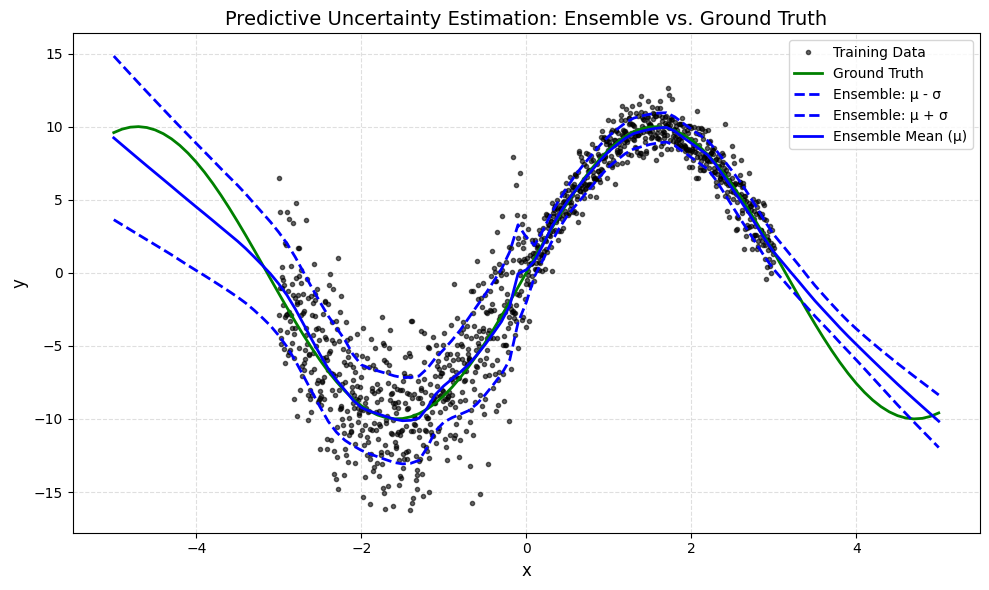

In [61]:
# ------------------------------------------
# Generate Unknown Input Dataset for Testing
# ------------------------------------------
x_test_grid = np.arange(-5, 5 + 0.1, 0.1)                         # Test input range from -5 to 5
x_test_grid = np.reshape(x_test_grid, [x_test_grid.shape[0], 1]) # Reshape to column vector

y_true_grid = np.zeros([x_test_grid.shape[0], 1])                # Ground truth output (no noise)

# Calculate ground truth using 10*sin(x)
for i in range(x_test_grid.shape[0]):
    y_true_grid[i, 0] = 10 * np.sin(x_test_grid[i, 0])

# ------------------------------------------
# Initialize Prediction Outputs
# ------------------------------------------

# Ensemble predictions
ensemble_mu_outputs = np.zeros([x_test_grid.shape[0], len(ensemble_models)])
ensemble_sigma_outputs = np.zeros([x_test_grid.shape[0], len(ensemble_models)])

# Single model prediction (only stores the last model's result)
single_model_mu = np.zeros([x_test_grid.shape[0], 1])
single_model_sigma = np.zeros([x_test_grid.shape[0], 1])

# ------------------------------------------
# Run Predictions for Each Ensemble Model
# ------------------------------------------
for model_index in range(len(ensemble_models)):
    mu_pred, sigma_pred = tf_session.run(
        [predicted_mu_list[model_index], predicted_sigma_list[model_index]],
        feed_dict={input_placeholders_list[model_index]: x_test_grid}
    )

    ensemble_mu_outputs[:, model_index] = np.reshape(mu_pred, (x_test_grid.shape[0],))
    ensemble_sigma_outputs[:, model_index] = np.reshape(sigma_pred, (x_test_grid.shape[0],))

    # Save prediction from the last model for comparison
    single_model_mu[:, 0] = np.reshape(mu_pred[:, 0], (x_test_grid.shape[0],))
    single_model_sigma[:, 0] = np.reshape(sigma_pred[:, 0], (x_test_grid.shape[0],))

# ------------------------------------------
# Compute Ensemble Mean and Total Uncertainty
# ------------------------------------------
final_ensemble_mu = np.mean(ensemble_mu_outputs, axis=1)
final_ensemble_sigma = np.sqrt(
    np.mean(ensemble_sigma_outputs, axis=1) +
    np.mean(np.square(ensemble_mu_outputs), axis=1) -
    np.square(final_ensemble_mu)
)



# ------------------------------------------
# Plot Final Results (Styled)
# ------------------------------------------
plt.figure(figsize=(10, 6))  # Set a larger figure size for better readability

# Original noisy training data
plt.plot(input_data_x, noisy_output_y, 'k.', alpha=0.6, label='Training Data')  # Black dots, semi-transparent

# Ground truth function: 10*sin(x)
plt.plot(x_test_grid, y_true_grid, 'g-', linewidth=2, label='Ground Truth')  # Green line

# Ensemble uncertainty bounds (mu ± sigma)
plt.plot(x_test_grid, final_ensemble_mu - final_ensemble_sigma, 'b--', linewidth=2, label='Ensemble: μ - σ')  # Blue dashed line
plt.plot(x_test_grid, final_ensemble_mu + final_ensemble_sigma, 'b--', linewidth=2, label='Ensemble: μ + σ')  # Blue dashed line

# Mean prediction line
plt.plot(x_test_grid, final_ensemble_mu, 'b-', linewidth=2, label='Ensemble Mean (μ)')  # Solid blue line

# Enhance plot appearance
plt.grid(True, linestyle='--', alpha=0.4)
plt.title('Predictive Uncertainty Estimation: Ensemble vs. Ground Truth', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()



## Comparison between Ensemble and Single network

## Plot: Comparison Between Ensemble and Single Network (Styled)

* plt.figure(figsize=(10, 6)):
    Creates a larger figure for better visual clarity.

* plt.plot(input_data_x, noisy_output_y, 'k.', alpha=0.5, label='Training Data'):
    Plots the original noisy training data as black semi-transparent dots.

* plt.plot(x_test_grid, final_ensemble_mu - final_ensemble_sigma, 'b--', ...):
    Plots the lower uncertainty bound (μ - σ) of the ensemble predictions using a dashed blue line.

* plt.plot(x_test_grid, final_ensemble_mu + final_ensemble_sigma, 'b--', ...):
    Plots the upper uncertainty bound (μ + σ) of the ensemble predictions using a dashed blue line.

* plt.plot(x_test_grid, single_model_mu + single_model_sigma, 'm-.', ...):
    Plots the upper uncertainty bound (μ + σ) from the single model using a magenta dash-dot line.

* plt.plot(x_test_grid, single_model_mu - single_model_sigma, 'm-.', ...):
    Plots the lower uncertainty bound (μ - σ) from the single model using a magenta dash-dot line.

* plt.plot(x_test_grid, final_ensemble_mu, 'b-', ...):
    Plots the ensemble mean prediction as a solid blue line.

* plt.plot(x_test_grid, single_model_mu, 'm-', ...):
    Plots the single model’s mean prediction as a solid magenta line.

* plt.grid(True, linestyle='--', alpha=0.4):
    Adds a light dashed grid to the plot for readability.

* plt.xlabel('x', ...), plt.ylabel('y', ...):
    Labels the x-axis and y-axis.

* plt.title(...):
    Adds a descriptive title highlighting the purpose of the comparison.

* plt.legend(loc='upper right', fontsize=10):
    Displays a legend to distinguish between ensemble and single model predictions.

* plt.tight_layout():
    Adjusts subplot parameters for a clean layout without overlapping elements.

* plt.show():
    Renders and displays the complete plot.


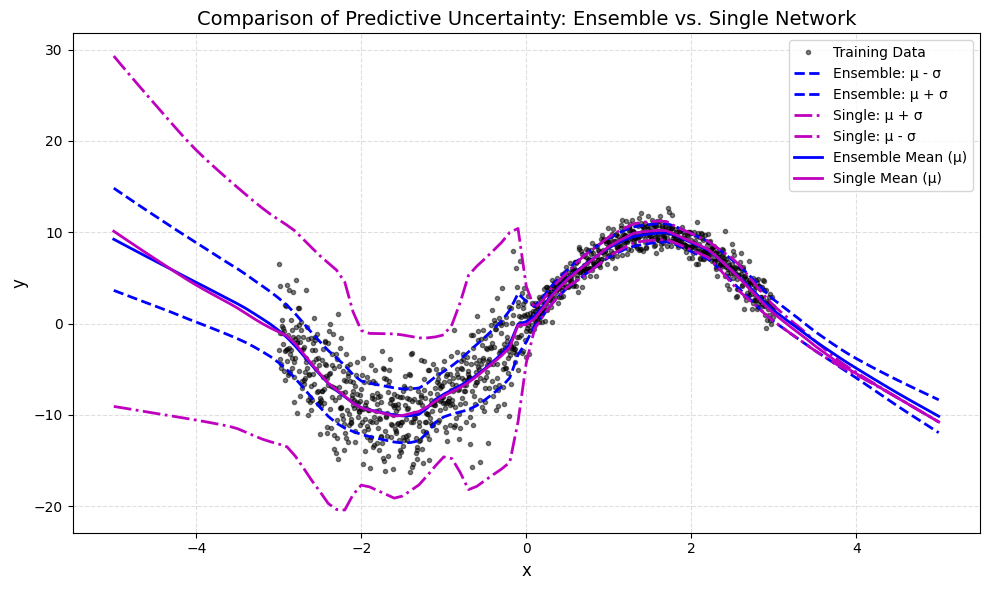

In [62]:
# ------------------------------------------
# Plot: Comparison Between Ensemble and Single Network (Styled)
# ------------------------------------------
plt.figure(figsize=(10, 6))  # Larger plot for clarity

# Plot original noisy dataset
plt.plot(input_data_x, noisy_output_y, 'k.', alpha=0.5, label='Training Data')  # Black semi-transparent dots

# Plot ensemble prediction uncertainty band
plt.plot(x_test_grid, final_ensemble_mu - final_ensemble_sigma, 'b--', linewidth=2, label='Ensemble: μ - σ')  # Dashed blue
plt.plot(x_test_grid, final_ensemble_mu + final_ensemble_sigma, 'b--', linewidth=2, label='Ensemble: μ + σ')

# Plot single network uncertainty band
plt.plot(x_test_grid, single_model_mu + single_model_sigma, 'm-.', linewidth=2, label='Single: μ + σ')  # Magenta dash-dot
plt.plot(x_test_grid, single_model_mu - single_model_sigma, 'm-.', linewidth=2, label='Single: μ - σ')

# Plot mean predictions (optional, but often helpful)
plt.plot(x_test_grid, final_ensemble_mu, 'b-', linewidth=2, label='Ensemble Mean (μ)')
plt.plot(x_test_grid, single_model_mu, 'm-', linewidth=2, label='Single Mean (μ)')

# Add grid, labels, and legend
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Comparison of Predictive Uncertainty: Ensemble vs. Single Network', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()
